In [103]:
pip install emoji

In [104]:
from __future__ import print_function
%matplotlib inline
import csv, re, sys
from io import StringIO
import requests
import numpy as np
import pandas as pd
import tensorflow as tf
import emoji, string
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score
from keras import layers, utils
from keras.models import Model, Sequential
from keras.layers import Conv1D, GlobalMaxPooling1D, GlobalAveragePooling1D, BatchNormalization, Activation, Concatenate, Dense, Dropout, Input, Flatten
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
#from keras.models import load_model
#from keras.models import model_from_json
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
import math
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import seaborn as sns
from sklearn.neural_network import MLPClassifier

pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
np.set_printoptions(threshold=sys.maxsize)


In [105]:
RANDOM_STATE = 1
EMBEDDING_SIZE = 100
MAX_LENGTH = 100

# **Define functions**

In [108]:
def load_dataset(url):
    r = requests.get(url)
    data = r.content.decode('utf8')
    df = pd.read_csv(StringIO(data), sep='\t')
    df.columns = ['tweet', 'label']
    return df


# clean text data
def clean_text(text):
  # remove url
  text = re.sub('http://\S+|https://\S+', '', text)
  # remove @sb. 
  text = re.sub('@\S+|@\S+', '', text)
  # remove #sth.
  text = re.sub('#\S+|#\S+','',text)
  # remove numbers
  text = re.sub(r'[0-9]+','',text)
  # remove other punctuations
  text = text.translate(str.maketrans('', '', string.punctuation))
  # remove emoji
  text = ''.join(c for c in text if c not in emoji.UNICODE_EMOJI)
  return text


def get_length(train, test):
  """get the max, mean, median character lengths of the tweets."""
  lengths_tr = [len(s.strip()) for s in train['tweet'] ]
  lengths_te = [len(s.strip()) for s in test['tweet']]
  print("maximum lengths in training and test data:",max(lengths_tr), max(lengths_te))
  print("average lengths in training and test data:", np.mean(lengths_tr), np.mean(lengths_te))
  print("medium lengths in training and test data:", np.median(lengths_tr), np.median(lengths_te))
  return max(max(lengths_tr), max(lengths_te))


def preprocess(df_train, df_test, MAX_LENGTH):
  """tokenize, character to index to sequence the text, one hot encoding to vectorize labels."""
  text_train = df_train['tweet']
  text_test = df_test['tweet']
  label_train = df_train['label']
  label_test = df_test['label']

  # character-level tokenization
  tokenizer = Tokenizer(num_words=None, lower=True, char_level=True)  
  tokenizer.fit_on_texts(text_train)
  X_train = tokenizer.texts_to_sequences(text_train)
  X_test = tokenizer.texts_to_sequences(text_test)

  char_size = len(tokenizer.word_index) + 1 

  print(text_train[5000])
  print(X_train[5000])

  X_train = pad_sequences(X_train, maxlen=MAX_LENGTH)
  X_test = pad_sequences(X_test, maxlen=MAX_LENGTH)

  # one-hot encoding for labels
  enc = LabelBinarizer().fit(label_train)
  y_train = enc.transform(label_train)
  y_test = enc.transform(label_test)

  return X_train, y_train, X_test, label_test, char_size
  


def create_model(num_filters, kernel_size, strides=1, char_size=5039, EMBEDING_SIZE=100, MAX_LENGTH=100):
    """create a CNN model, use it in grid search cv, to get best num_filters and kernel size."""
    model = Sequential()
    model.add(layers.Embedding(char_size, EMBEDDING_SIZE, input_length=MAX_LENGTH))
    model.add(layers.Conv1D(num_filters, kernel_size, strides=1, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(Dropout(0.2))
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(69, activation='softmax'))
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model



def get_model(X,y,char_size,pooling='GlobalMax', dropout=True, strides=1, batch_size=32, optim='adam',epochs=300):
    """train models by choosing different pooling strategy, dropout, batch size and optimizer."""

    # initialize CNN model
    model = Sequential()
    model.add(layers.Embedding(input_dim=char_size, output_dim=EMBEDDING_SIZE, input_length=MAX_LENGTH, trainable=False))
    model.add(Conv1D(128, 3, activation='relu', strides=strides)) 
    if pooling=='GlobalMax':
      model.add(GlobalMaxPooling1D())
    elif pooling=='GlobalAve':
      model.add(GlobalAveragePooling1D())
    if dropout:
      model.add(Dropout(0.2))
    model.add(Dense(100,activation='relu'))
    model.add(Dense(69, activation='softmax'))
    model.compile(optimizer=optim, loss='categorical_crossentropy',metrics=['categorical_accuracy'])
    model.summary()

    # split dataset into training and validation sets
    Xtrain, Xval, ytrain, yval = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE )

    # define early stop
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)

    # fit model on training set and validate on validation set
    history = model.fit(Xtrain,ytrain,epochs=epochs,verbose=2,validation_data=(Xval,yval), callbacks=[es],batch_size=batch_size)
    loss, accuracy = model.evaluate(Xtrain, ytrain,verbose=1)
    print("Training loss: {:.4f}, Traning accuracy: {:.4f}".format(loss, accuracy))
    loss, accuracy = model.evaluate(Xval,yval,verbose=1)
    print("Validation loss:  {:.4f}, Validation accuracy: {:.4f}".format(loss, accuracy))

    return model 


def prediction(model, X_test, label_test, unique_labels):
  """predict test labels, calculate accuracy."""
  y_pred_probs = model.predict(X_test)
  #print(y_pred_probs[0])
  y_pred_idx = [np.argmax(y_pred_probs[i]) for i in range(len(y_pred_probs))]
  y_pred_label = [unique_labels[idx] for idx in y_pred_idx]
  accuracy = accuracy_score(y_pred_label, label_test)
  print("Test Accuracy is: {:.4f}".format(accuracy))
  return accuracy


# **Load files into dataframes**

In [109]:
url_train_dev = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTOZ2rC82rhNsJduoyKYTsVeH6ukd7Bpxvxn_afOibn3R-eadZGXu82eCU9IRpl4CK_gefEGsYrA_oM/pub?gid=1863430984&single=true&output=tsv'
url_test = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vT-KNR9nuYatLkSbzSRgpz6Ku1n4TN4w6kKmFLkA6QJHTfQzmX0puBsLF7PAAQJQAxUpgruDd_RRgK7/pub?gid=417546901&single=true&output=tsv'

In [110]:
df_train_dev = load_dataset(url_train_dev)
df_test = load_dataset(url_test)

# **Inspect the data**

In [111]:
df_train_dev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52675 entries, 0 to 52674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   52675 non-null  object
 1   label   52675 non-null  object
dtypes: object(2)
memory usage: 823.2+ KB


In [112]:
df_train_dev.head()

,tweet,label
0,يا من أناديها ويخنقني البكاء ويكاد صمت الدمع ...,ar
1,فيه فرق بين اهل غزة اللى مطحونين من ناحيتين وب...,ar
2,ﻋﻦ ﺍﻟﻠﺤﻈﺔ اﻟﺤﻠﻮﺓﺓ ﺍﻟﻠﻲ ﺑﺘﻐﻤﺾ ﻓﻴﻬﺎ ﻋﻴﻨﻴﻚ ﺑﺘﻔﻜﺮ ...,ar
3,يا ابو سلو عرفتني,ar
4,ب50 ريال أكفل معتمر في رمضان ، ولك بإذن الله م...,ar


In [ ]:
print(df_train_dev.groupby(['label']).count())


         tweet
label         
ar        2199
ar_LATN     12
az           1
bg           2
bn           8
bs           4
ca          22
cs           4
cy           1
da           7
de         171
dv           1
el          28
en       18508
es        5930
et           2
fa          18
fi          15
fr         946
gl           3
ha           1
he          27
hi          16
hi-Latn     15
hr           5
ht           2
hu          15
hy           2
id        3006
is           1
it         339
ja       10421
ja_LATN      1
jv          10
km           2
ko         458
ko_LATN      1
ms         119
ne           5
nl         182
no          11
pl          93
ps           1
ps_LATN      1
pt        2878
ro          12
ru         978
si           1
sl           2
sq           9
sr          22
su          10
sv          54
sw           6
ta           9
ta_LATN      1
th         462
tl         320
tn           1
tr         669
uk          16
und       4537
ur           7
ur_LATN     12
vi        

In [113]:
unique_labels = df_train_dev.label.unique()
len(unique_labels)

69

In [114]:
# unique labels in test set
len(df_test.label.unique())


60

# **Clean the data**
* remove url
* remove "#topics", "@sb"
* remove numbers
* remove punctuations
* remove emoji

In [115]:
df_train_dev['tweet'] = df_train_dev['tweet'].apply(clean_text)
df_test['tweet'] = df_test['tweet'].apply(clean_text)

In [116]:
# character length of tweets
get_length(df_train_dev, df_test)

maximum lengths in training and test data: 5979 3602
average lengths in training and test data: 43.219003322259134 43.388658784547026
medium lengths in training and test data: 34.0 35.0


5979

#  **Preprocess / vectorization**
* one-hot encoding to vectorize labels
* character indices to encode texts

In [117]:
X_train, y_train, X_test, label_test, char_size = preprocess(df_train_dev, df_test,MAX_LENGTH)

at the very least I ate the whole Slayer burger
[3, 6, 1, 6, 14, 2, 1, 23, 2, 9, 18, 1, 10, 2, 3, 8, 6, 1, 5, 1, 3, 6, 2, 1, 6, 14, 2, 1, 21, 14, 4, 10, 2, 1, 8, 10, 3, 18, 2, 9, 1, 19, 11, 9, 16, 2, 9]


In [118]:
char_size

5039

# **Hyperparameter Search by RandomizedSearchCV**

In [ ]:
param_grid = dict(num_filters=[64, 128],
                  kernel_size=[3, 5])

In [ ]:
model = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model,
                            epochs=40, batch_size=32,
                            verbose=False)
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                              cv=4, verbose=1, n_iter=1)
grid_result = grid.fit(X_train, y_train)

print(grid_result)
print(grid_result.best_score_)
print(grid_result.best_params_)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 20.8min finished


RandomizedSearchCV(cv=4, error_score=nan,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f82e0c276d8>,
                   iid='deprecated', n_iter=1, n_jobs=None,
                   param_distributions={'kernel_size': [3, 5],
                                        'num_filters': [64, 128]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=1)
0.6232661493122578
{'num_filters': 128, 'kernel_size': 3}


# **Train the Anchor Model and Predict Test Labels**

In [ ]:
# train and validate model
model_an = get_model(X_train, y_train, char_size)

# predict on test set
print("-------------prediction accuracy--------------")
prediction(model_an, X_test, label_test, unique_labels)

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_31 (Embedding)     (None, 100, 100)          503900    
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 98, 128)           38528     
_________________________________________________________________
global_max_pooling1d_27 (Glo (None, 128)               0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_62 (Dense)             (None, 100)               12900     
_________________________________________________________________
dense_63 (Dense)             (None, 69)                6969      
Total params: 562,297
Trainable params: 58,397
Non-trainable params: 503,900
__________________________________________

0.9291362301378115

# **Change Pooling Strategy**

In [ ]:
model_ave = get_model(X_train, y_train, char_size, pooling='GlobalAve')

# predict on test set
print("-------------prediction accuracy--------------")
prediction(model_ave, X_test, label_test, unique_labels)

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_32 (Embedding)     (None, 100, 100)          503900    
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 98, 128)           38528     
_________________________________________________________________
global_average_pooling1d_4 ( (None, 128)               0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_64 (Dense)             (None, 100)               12900     
_________________________________________________________________
dense_65 (Dense)             (None, 69)                6969      
Total params: 562,297
Trainable params: 58,397
Non-trainable params: 503,900
__________________________________________

0.9305670607726485

# **Remove Dropout**

In [ ]:
model = get_model(X_train, y_train, char_size, dropout=False)

# predict on test set
print("-------------prediction accuracy--------------")
prediction(model, X_test, label_test, unique_labels)

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_33 (Embedding)     (None, 100, 100)          503900    
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 98, 128)           38528     
_________________________________________________________________
global_max_pooling1d_28 (Glo (None, 128)               0         
_________________________________________________________________
dense_66 (Dense)             (None, 100)               12900     
_________________________________________________________________
dense_67 (Dense)             (None, 69)                6969      
Total params: 562,297
Trainable params: 58,397
Non-trainable params: 503,900
_________________________________________________________________
Epoch 1/300
1317/1317 - 4s - loss: 0.9042 - categorical_accuracy: 0.7562 - val_loss: 0.4924 - val_categorica

0.9186685744408465

# **Decrease Batch Size to 16**

In [ ]:
model = get_model(X_train, y_train, char_size, batch_size=16)

# predict on test set
print("-------------prediction accuracy--------------")
prediction(model, X_test, label_test, unique_labels)

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_34 (Embedding)     (None, 100, 100)          503900    
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 98, 128)           38528     
_________________________________________________________________
global_max_pooling1d_29 (Glo (None, 128)               0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_68 (Dense)             (None, 100)               12900     
_________________________________________________________________
dense_69 (Dense)             (None, 69)                6969      
Total params: 562,297
Trainable params: 58,397
Non-trainable params: 503,900
__________________________________________

0.9283831613826342



# **Change Strides**


In [ ]:
model = get_model(X_train, y_train, char_size, strides=5)

# predict on test set
print("-------------prediction accuracy--------------")
prediction(model, X_test, label_test, unique_labels)

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_35 (Embedding)     (None, 100, 100)          503900    
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 20, 128)           38528     
_________________________________________________________________
global_max_pooling1d_30 (Glo (None, 128)               0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_70 (Dense)             (None, 100)               12900     
_________________________________________________________________
dense_71 (Dense)             (None, 69)                6969      
Total params: 562,297
Trainable params: 58,397
Non-trainable params: 503,900
__________________________________________

0.8629414865577227

# **Change Optimizer**

In [ ]:
model = get_model(X_train,y_train,char_size,optim='sgd')

# predict on test set
print("-------------prediction accuracy--------------")
prediction(model, X_test, label_test, unique_labels)

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_36 (Embedding)     (None, 100, 100)          503900    
_________________________________________________________________
conv1d_36 (Conv1D)           (None, 98, 128)           38528     
_________________________________________________________________
global_max_pooling1d_31 (Glo (None, 128)               0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_72 (Dense)             (None, 100)               12900     
_________________________________________________________________
dense_73 (Dense)             (None, 69)                6969      
Total params: 562,297
Trainable params: 58,397
Non-trainable params: 503,900
__________________________________________

0.9175389713080804

# **Confusion Matrix to Measure the Best Model**

In [ ]:
y_pred_probs = model_ave.predict(X_test)
y_pred_idx = [np.argmax(y_pred_probs[i]) for i in range(len(y_pred_probs))]
pred_labels = [unique_labels[idx] for idx in y_pred_idx]

# confusion matrices
test_labels = df_test['label'].unique()

cm =  confusion_matrix(df_test['label'], pred_labels, labels=test_labels)
cm = pd.DataFrame(cm, index=test_labels, columns=test_labels)
print(cm)
cm.to_csv("confusion matrix.csv",index=True, header=True)

           en  und    es    ja   id   pt   ar  th   fr   tr  ms   ru  hi-Latn  \
en       4661   57     6     1    8    6    0   0    8    0   0    1        0   
und       131  923    44    10   59   12    4   0    7   11   0    7        1   
es         13   35  1400     0    2   17    0   0    3    1   0    0        0   
ja          2    9     0  2458    1    1    0   3    1    0   0    0        0   
id         26   52     3     1  719    4    0   0    2    4   0    0        0   
pt         11   18    39     0    1  621    0   0    4    0   0    0        0   
ar          0    0     0     2    0    0  525   2    0    0   0    0        0   
th          0    0     0     0    0    0    0  97    0    0   0    1        0   
fr         14   10     4     0    0    3    0   0  193    0   0    0        0   
tr          3    4     0     0    3    0    0   0    0  164   0    0        0   
ms          1    4     0     0   22    0    0   0    0    1   2    0        0   
ru          0    0     0    

**average macro precision, recall**

In [ ]:
# average macro precision and recall 
ave_precision = precision_score(df_test['label'], pred_labels, labels=test_labels, average='macro')
ave_recall = recall_score(df_test['label'], pred_labels, labels=test_labels, average='macro')
print("average macro (precision, recall) of CNN: ", (ave_precision, ave_recall))

average macro (precision, recall) of CNN:  (0.43468218627991834, 0.36771720369235594)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**macro precision and recall for each class**

In [ ]:
# precision and recall of each label
precision = precision_score(df_test['label'], pred_labels, labels=test_labels, average=None).reshape(-1,1)
recall = recall_score(df_test['label'], pred_labels, labels=test_labels, average=None).reshape(-1,1)

# concatenate precision and recall of each model
metrics = np.concatenate([precision, recall],axis=1)

# add column names and row index labels, print metrics 
metrics = pd.DataFrame(metrics, columns=['precision', 'recall'])
metrics.index = test_labels

print('\nprecision and recall of each class: \n', metrics)


precision and recall of each class: 
          precision    recall
en        0.952585  0.979613
und       0.795004  0.751017
es        0.928382  0.948509
ja        0.985961  0.991929
id        0.866265  0.880049
pt        0.922734  0.888412
ar        0.988701  0.992439
th        0.941748  0.989796
fr        0.865471  0.861607
tr        0.877005  0.942529
ms        1.000000  0.064516
ru        0.937255  0.983539
hi-Latn   0.000000  0.000000
bs        0.000000  0.000000
xh        0.000000  0.000000
ko        0.911765  0.845455
it        0.849315  0.815789
tl        0.698795  0.651685
sv        0.909091  0.666667
ta        1.000000  1.000000
he        0.923077  0.857143
de        0.950000  0.760000
el        0.888889  0.727273
pl        0.900000  0.692308
nl        0.888889  0.744186
fa        0.600000  0.600000
mr        0.000000  0.000000
ar_LATN   0.000000  0.000000
sr        0.750000  0.428571
sw        1.000000  0.500000
ur        1.000000  0.600000
ca        0.000000  0.000000
vi  

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(df_test.groupby(['label']).count())

         tweet
label         
ar         529
ar_LATN      3
az           2
bg           2
bs           1
ca           3
cs           1
da           1
de          50
el          11
en        4758
es        1476
eu           2
fa           5
fi           8
fr         224
he          14
hi           4
hi-Latn      4
hr           1
ht           1
id         817
it          76
ja        2478
ja_LATN      1
jv           1
km           1
ko         110
ko_LATN      1
la           1
lv           5
mk           1
mn           1
mr           1
ms          31
nl          43
no           1
pl          26
pt         699
ro           2
ru         243
sk           1
sr           7
sv          15
sw           2
ta           3
ta_LATN      1
th          98
tl          89
tr         174
uk           2
und       1229
ur           5
ur_LATN      1
vi           5
xh           1
yo           1
zh-CN        1
zh-TW        4
zu           1


# **Heatmap Correlation**

In [ ]:
# global max pooling: 0, global average pooling:1
# optimizer='adam':0, optimizer='sgd':1
table = pd.DataFrame([[0,0.2,32,1,0,0.9291],[1,0.2,32,1,0,0.9306], 
         [0,0,32,1,0,0.9187],[0,0.2,16,1,0,0.9284],[0,0.2,32,5,0,0.8629],[0,0.2,32,1,1,0.9175]],
          columns=['pooling strategy','dropout','batch size','strides','optimizer','accuracy'])
table


,pooling strategy,dropout,batch size,strides,optimizer,accuracy
0,0,0.2,32,1,0,0.9291
1,1,0.2,32,1,0,0.9306
2,0,0.0,32,1,0,0.9187
3,0,0.2,16,1,0,0.9284
4,0,0.2,32,5,0,0.8629
5,0,0.2,32,1,1,0.9175


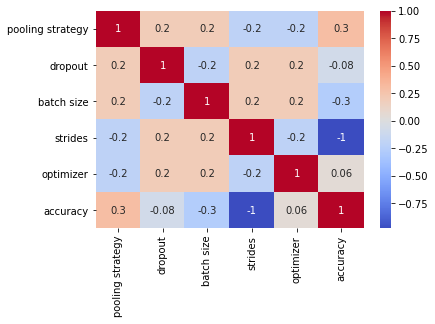

In [ ]:
sns.heatmap(table.corr(),annot=True, fmt='.1g', cmap= 'coolwarm')

# **Compare with MLP**
MLP is the best model in Ex01.
As the data preprocess is different here from Ex01, so here I train the MLP again. 

In [119]:
# train models
mlp = MLPClassifier(hidden_layer_sizes=(800,),shuffle=True, random_state=RANDOM_STATE, verbose=True, activation='tanh', solver='adam', early_stopping=True)
mlp.fit(X_train, y_train)

# predict on test set
print("-------------prediction accuracy--------------")
prediction(mlp, X_test, label_test, unique_labels)

Iteration 1, loss = 4.26667468
Validation score: 0.317578
Iteration 2, loss = 2.59435415
Validation score: 0.279803
Iteration 3, loss = 2.41048761
Validation score: 0.401291
Iteration 4, loss = 2.30742557
Validation score: 0.454252
Iteration 5, loss = 2.23086669
Validation score: 0.431283
Iteration 6, loss = 2.17749465
Validation score: 0.430524
Iteration 7, loss = 2.12853890
Validation score: 0.354784
Iteration 8, loss = 2.08967746
Validation score: 0.424260
Iteration 9, loss = 2.03874302
Validation score: 0.395786
Iteration 10, loss = 2.00305406
Validation score: 0.413629
Iteration 11, loss = 1.97431382
Validation score: 0.457479
Iteration 12, loss = 1.95007042
Validation score: 0.464313
Iteration 13, loss = 1.93143979
Validation score: 0.433751
Iteration 14, loss = 1.90136044
Validation score: 0.474943
Iteration 15, loss = 1.86623576
Validation score: 0.457479
Iteration 16, loss = 1.85407321
Validation score: 0.456150
Iteration 17, loss = 1.82918793
Validation score: 0.512149
Iterat

0.5674373070261315

**macro precision, recall of MLP**

In [120]:
y_pred_probs = mlp.predict(X_test)
y_pred_idx = [np.argmax(y_pred_probs[i]) for i in range(len(y_pred_probs))]
pred_labels = [unique_labels[idx] for idx in y_pred_idx]

# average macro precision and recall 
ave_precision = precision_score(df_test['label'], pred_labels, labels=test_labels, average='macro')
ave_recall = recall_score(df_test['label'], pred_labels, labels=test_labels, average='macro')
print("average macro (precision, recall) of the MLP: ", (ave_precision, ave_recall))

average macro (precision, recall) of the MLP:  (0.10010165566557795, 0.05949356025692754)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
